# Track Corona Sequences to Locations in Germany

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from Bio import SeqIO as sio
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

## Parameters & Constants

In [2]:
#cases_url = 'https://opendata.arcgis.com/datasets/ef4b445a53c1406892257fe63129a8ea_0.csv'
cases_url = 'https://opendata.arcgis.com/datasets/917fc37a709542548cc3be077a786c17_0.csv'

## Distances Between Sequences

In [3]:
seq_names_germany_gisaid = [s.name for s in sio.parse('data/gisaid_cov2020_germany_sequences.fasta',
                                               format='fasta')]
seq_names_germany_charite = [s.name for s in sio.parse('data/charite-SARS-CoV-2.fasta', format='fasta')]
seq_names_germany = seq_names_germany_gisaid + seq_names_germany_charite

In [5]:
# get the distances in the tree
tree_distances = pd.read_csv('tree_distances_all', sep='\t')
tree_distances = 1 - tree_distances / float(tree_distances.max().max())

def extract_loc(s):
    res = None
    try:
        return s.split('|')[0].split('/')[1].strip()
    except:
        return np.nan

# German distances
german_distances = tree_distances[tree_distances.index.isin(seq_names_germany_charite)][seq_names_germany_charite]

# aggregate to obtain distances for Bundeslaender
charite_meta = pd.read_csv('data/charite-SARS-CoV-2.tsv.gz',
                           sep='\t', compression='gzip')
charite_meta.set_index('strain', inplace=True)
get_location = lambda idx: (charite_meta[charite_meta.index == idx].city.values)[0]
city_dist = german_distances.groupby(get_location).median().T.groupby(get_location).median()
city_dist = city_dist.drop('unknown').drop('unknown', axis=1)

## Get Location of Origin for Sequences

In [6]:
geolocator = Nominatim(user_agent="CoronaTree")
locations_cities = {}
for city in charite_meta.city.value_counts().index:
    print (city)
    if not city == 'unknown':
        time.sleep(1) # required for the geolocation service (1 request/sec)
        location = geolocator.geocode(city)
        if not location is None:
            locations_cities[city] = (location.longitude, location.latitude)

unknown
Berlin
Munich
Rhein-Kreis Neuss
Bremerhaven
Rastede
Lauben
Kiel
Koblenz
Bad Duerkheim Kreis
Duesseldorf
Neumuenster
Rheinisch-Bergischer Kreis
Ploen
Kaiserslautern
Rhein-Neckar Kreis
Weitenhagen
Flensburg
Rotenburg
Karlsruhe
Ettlingen
Heidelberg


In [7]:
cases_germany = pd.read_csv(cases_url)
geolocator = Nominatim(user_agent="CoronaTree")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
cases_germany['location'] = cases_germany.GEN.apply(geocode)

## Mapping the Sequences to Germany
We use basemap to build a map of Germany and use location services to extract the coordinates of a place.

/home/sasse/anaconda3/envs/wirvsvirus/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/sasse/anaconda3/envs/wirvsvirus/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


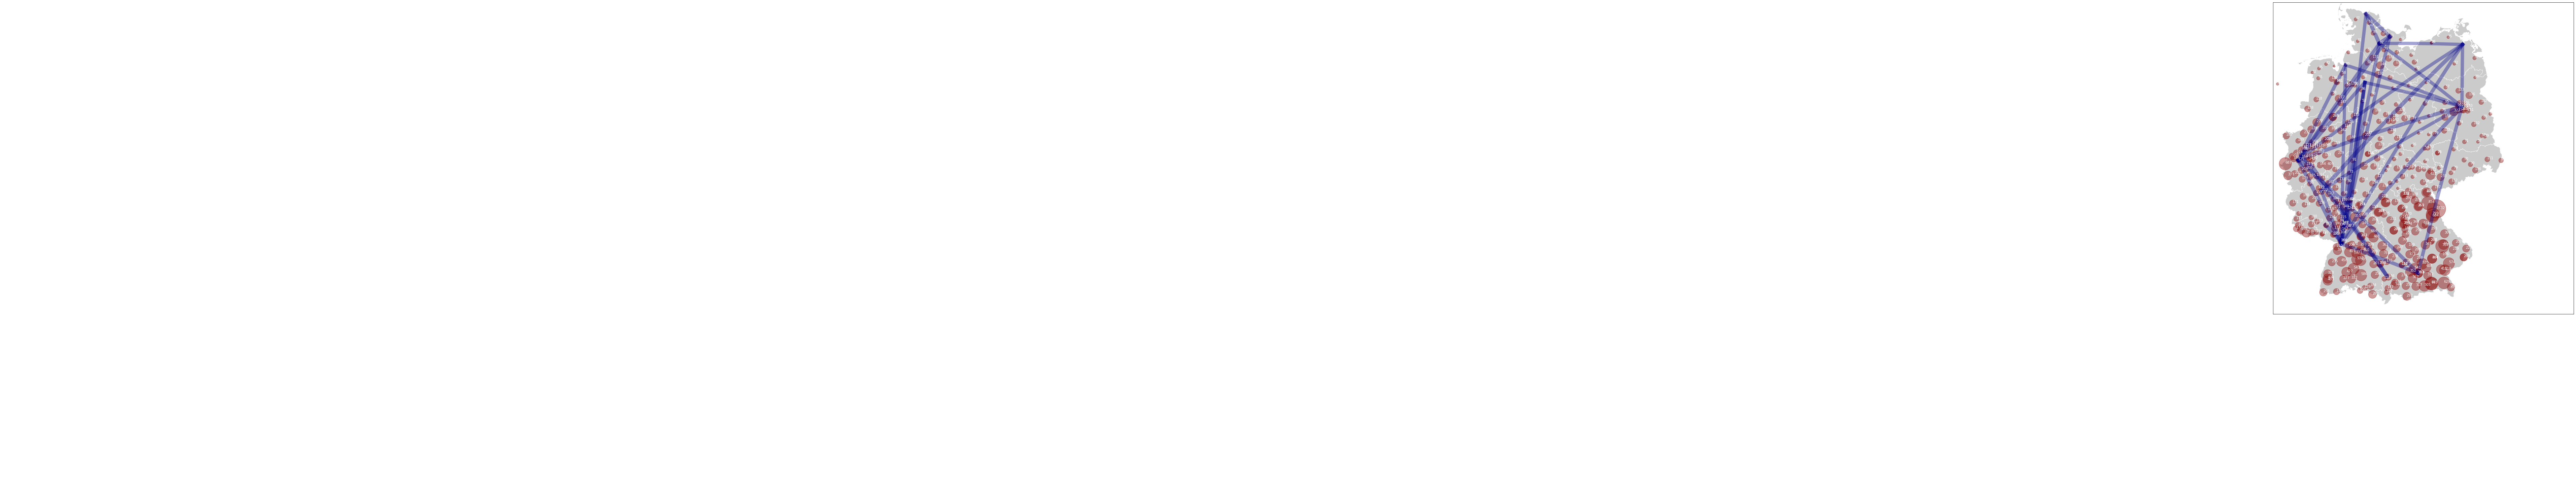

In [14]:
# Create figure
fig = plt.figure(figsize=(16, 20))
ax = fig.gca()

left, right, bottom, top = 5.6, 18.0, 47.0, 55.06 # Germany (5.87, ..., 47.26, ...)
m = Basemap(projection='merc', resolution='l', llcrnrlat=bottom,
            llcrnrlon=left, urcrnrlat=top, urcrnrlon=right)


m.readshapefile('data/shapefiles/DEU_adm1', 'shp', drawbounds=True, color='w', zorder=1)
scale = np.array([np.ptp(shape, axis=0) for shape in m.shp]).max(axis=0)
position = np.array([np.min(shape, axis=0) for shape in m.shp]).min(axis=0)

# Extract shape of states and set a background color
patches = []
for info, shape in zip(m.shp_info, m.shp):
    polygons = np.array(shape)
    patches.append(Polygon(polygons, True, color='darkgray', alpha=0.6))

pc = PatchCollection(patches, match_original=True, edgecolor=None, zorder=0)
ax.add_collection(pc)

# draw circles with numbers of cases per 100,000 inhabitants
for idx, row in cases_germany.iterrows():
    cases_per_100k = row.cases_per_100k
    xp, yp = m(row.location.longitude, row.location.latitude)
    m.scatter(xp, yp, color='darkred', marker='o',
              s=2*cases_per_100k, alpha=0.4)
    plt.annotate('{}'.format(round(cases_per_100k)), xy=(xp, yp), color='white')#xy=(xp-15000, yp-50000), color='white')


# draw the lines between places
for src, row in city_dist.iterrows():
    if src in locations_cities:
        coords_src = locations_cities[src]
        for tgt, value in row.iteritems():
            if tgt in locations_cities:
                coords_tgt = locations_cities[tgt]
                if value > 0.8:
                    m.drawgreatcircle(*coords_src, *coords_tgt,
                                      lw=12*value, color='darkblue',
                                      alpha=0.2
                                     )
fig.savefig('germany_connections.png', dpi=300)

## Mapping All  GISAID Sequences to Europe
We use the [GISAID](https://www.gisaid.org/) database and extract the genomic sequences of covid-19 from them. Here, we visualize the cases on a map of Europe.

In [7]:
# get locations of the sequences
extract_loc = lambda s: s.description.split('|')[0].split('/')[1].strip()
all_gisaid_covseq = [extract_loc(s) for s in sio.parse('data/gisaid_cov2020_sequences.fasta', format='fasta')]
location_numbers = pd.DataFrame(pd.Series(all_gisaid_covseq).value_counts(), columns=['N'])
location_numbers['Country'] = location_numbers.index

longs = []
lats = []
geolocator = Nominatim(user_agent="CoronaTree")
for name, row in location_numbers.iterrows():
    try:
        location = geolocator.geocode(row.Country)
        longs.append(location.longitude)
        lats.append(location.latitude)
    except:
        print (row.Country)
        longs.append(np.nan)
        lats.append(np.nan)

location_numbers['Long'] = longs
location_numbers['Lat'] = lats
location_numbers.dropna(inplace=True)

NetherlandsL


In [8]:
(country_distances > 0.5).sum().sum()

56

/home/sasse/anaconda3/envs/wirvsvirus/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/home/sasse/anaconda3/envs/wirvsvirus/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


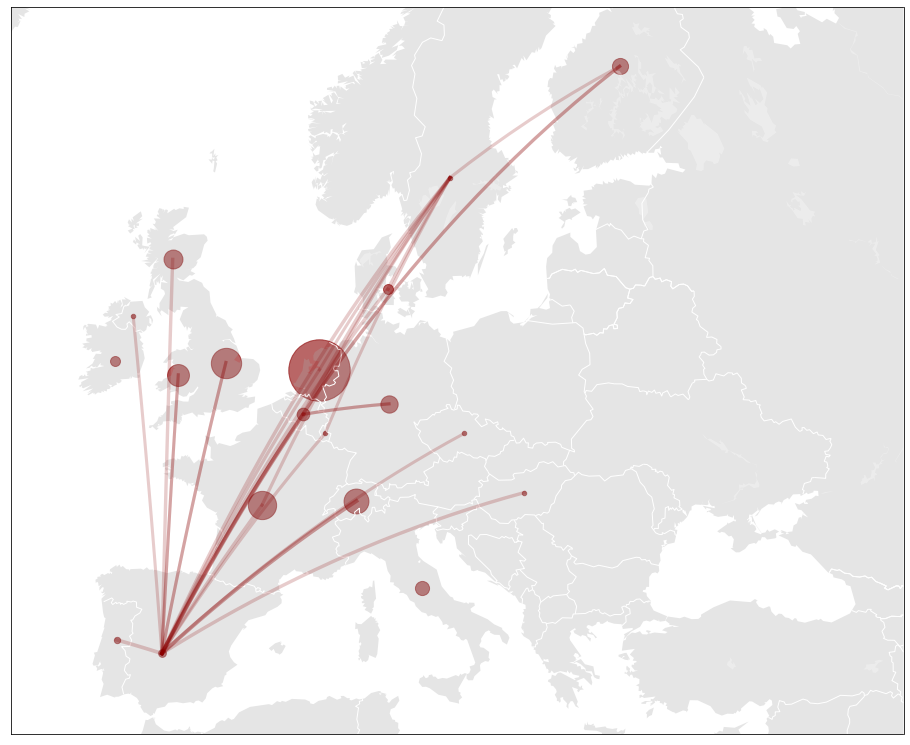

In [9]:
# Create figure
fig = plt.figure(figsize=(16, 20))
ax = fig.gca()

left, right, bottom, top = -15, 45, 35, 65 # Germany (5.87, ..., 47.26, ...)
m = Basemap(projection='merc', resolution='l', llcrnrlat=bottom,
            llcrnrlon=left, urcrnrlat=top, urcrnrlon=right)
x = m.drawcountries(color='white', linewidth=1)
#m.drawcoastlines()
_ = m.fillcontinents(color='darkgray',lake_color='white', alpha=0.3)

for name, row in location_numbers.iterrows():
    xp, yp = m(row.Long, row.Lat)
    m.scatter(xp, yp, color='darkred', marker='o', s=20*row.N, alpha=0.6)

geolocator = Nominatim(user_agent="CoronaTree")
for src, row in country_distances.iterrows():
    try:
        location = geolocator.geocode(src)
        coords_src = (location.longitude, location.latitude)
    except:
        continue
    for target, value in row.iteritems():
        if value > 0.5:
            try:
                tgt_loc = geolocator.geocode(target.replace('_', ' '))
                coords_tgt = (tgt_loc.longitude, tgt_loc.latitude)
            except:
                continue
            m.drawgreatcircle(*coords_src, *coords_tgt, lw=6*value, color='darkred', alpha=0.2)
fig.savefig('europe_cases_connections.png', dpi=300)

In [10]:
location_numbers

,N,Country,Long,Lat
Netherlands,189,Netherlands,5.748082,52.500170
England,46,England,-0.540240,52.795479
France,40,France,1.888334,46.603354
Switzerland,31,Switzerland,8.231974,46.798562
Wales,24,Wales,-3.738930,52.292812
Scotland,18,Scotland,-4.114052,56.786111
Germany,15,Germany,10.423447,51.083420
Finland,13,Finland,25.920916,63.246778
Italy,10,Italy,12.674297,42.638426
Belgium,8,Belgium,4.666715,50.640281


In [11]:
country_distances.median().idxmax()

'Spain'

/home/sasse/anaconda3/envs/wirvsvirus/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


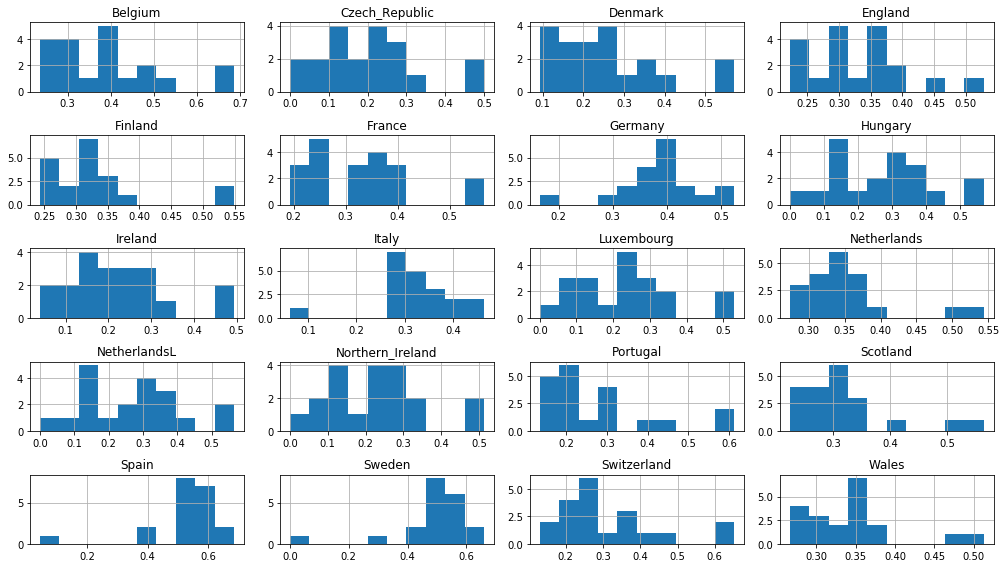

In [12]:
fig = plt.figure(figsize=(14, 8))
_ = country_distances.hist(ax=plt.gca())
plt.tight_layout()

(array([12., 30., 30., 77., 91., 78., 18., 38., 18.,  8.]),
 array([0.        , 0.06866197, 0.13732394, 0.20598592, 0.27464789,
        0.34330986, 0.41197183, 0.4806338 , 0.54929577, 0.61795775,
        0.68661972]),
 <a list of 10 Patch objects>)

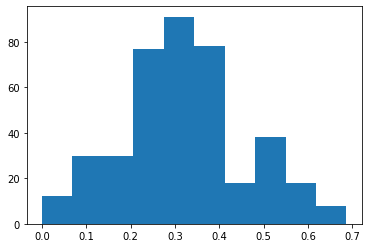

In [13]:
plt.hist(country_distances.values.flatten())

In [7]:
metadata_seqs = pd.read_csv('data/corona_sequences_metadata.csv', sep='\t')
seq_names = [s.name.split('|')[1] for s in sio.parse('data/corona_germany_aligned.fasta', format='fasta')]
coordinates = []
names = []
for seq_name in seq_names:
    location_name = str(metadata_seqs[metadata_seqs.ID == seq_name].Place.values[0])
    names.append(metadata_seqs[metadata_seqs.ID == seq_name].Name.values[0])
    location = geolocator.geocode(location_name)
    if not location is None:
        coordinates.append([location_name, location.longitude, location.latitude])
seq_location_df = pd.DataFrame(coordinates, columns=['Place', 'Long', 'Lat'], index=names)
samples_places = seq_location_df.groupby('Place').mean()
samples_places['N'] = seq_location_df.Place.value_counts()


IndexError: list index out of range

In [ ]:
# draw the edges according to sequence similarity
geolocator = Nominatim(user_agent="CoronaTree")
for src, row in bl_dist.iterrows():
    try:
        location = geolocator.geocode(src)
        coords_src = (location.longitude, location.latitude)
    except:
        continue
    for tgt, value in row.iteritems():
        try:
            tgt_loc = geolocator.geocode(tgt.replace('_', ' '))
            coords_tgt = (tgt_loc.longitude, tgt_loc.latitude)
        except:
            continue
        if value > 0.2:
            m.drawgreatcircle(*coords_src, *coords_tgt, lw=12*value, color='darkred', alpha=0.2)
